# Analyse ROMY Events

In [ ]:
import os
import numpy as np
import yaml
import matplotlib.pyplot as plt

from pandas import read_pickle
from obspy import UTCDateTime
from sixdegrees.sixdegrees import sixdegrees

from sixdegrees.plots.plot_tangent_method_comparison import plot_tangent_method_comparison
from sixdegrees.plots.plot_frequency_backazimuth_analysis import plot_frequency_backazimuth_analysis
from sixdegrees.plots.plot_backazimuth_deviation_analysis import plot_backazimuth_deviation_analysis
from sixdegrees.plots.plot_backazimuth_map import plot_backazimuth_map

from sixdegrees.utils.print_deviation_summary import print_deviation_summary


## Configurations

In [2]:
config = {
    # Required time window parameters
    'tbeg': "2023-09-08 22:13:00",  # Start time
    'tend': "2023-09-08 23:00:00",  # End time

    # event
    'origin_time': "2023-09-08 22:11:00",
    'magnitude': 6.8,

    # Station coordinates (required)
    'station_lon': 11.275476,  # BSPF longitude
    'station_lat': 48.162941,    # BSPF latitude
    
    # SEED identifiers
    'seed': "XX.ROMY..",     # Default seed ID
    'rot_seed': ["XX.ROMY..BJZ", "XX.ROMY..BJN", "XX.ROMY..BJE"], # "BW.ROMY.30.BJ*",  # Rotation sensor seed ID
    'tra_seed': ["XX.ROMY..BHZ", "XX.ROMY..BHN", "XX.ROMY..BHE"],  # Translation sensor seed ID
    
    # Data source
    'data_source': "mseed_file",  # "fdsn" | "sds" | "mseed_file"

    # Path to local mseed file
    'path_to_mseed_file': "./data/romy_eventM6.8.mseed",  # "./data/eventM62_6c.mseed",

    # Path configurations
    'workdir': "./",            # Working directory
    'path_to_data_out': "./output/",  # Output directory

    # Project information
    'project': "ROMY_Analysis",  # Project name
    
    # Optional parameters
    'verbose': True,            # Print detailed information
}

Setup a sixdegrees object

In [3]:
sd = sixdegrees(conf=config)

Get key information about the event

In [4]:
ev = sd.get_event_info(
    origin_time=config['origin_time'],
    base_catalog="USGS",
    magnitude=config['magnitude']
)

Found event:
Origin time: 2023-09-08T22:11:01.405000Z
Magnitude: 6.8 mww
Location: 31.058°N, -8.385°E
Depth: 19.0 km
Epicentral Distance: 2526.0 km
Epicentral Distance: 22.7°
Backazimuth: 228.4°


This will load the data from the data source:
- local mseed file
- local sds system
- fdsn (online)

and trim it to the time window

In [5]:
sd.load_data(config['tbeg'], config['tend'])

-> fetching XX.ROMY..BHZ data from mseed file
-> fetching XX.ROMY..BHN data from mseed file
-> fetching XX.ROMY..BHE data from mseed file
3 Trace(s) in Stream:
XX.ROMY..BHZ | 2023-09-08T22:12:58.989999Z - 2023-09-08T23:00:00.989999Z | 20.0 Hz, 56441 samples
XX.ROMY..BHN | 2023-09-08T22:12:58.990000Z - 2023-09-08T23:00:00.990000Z | 20.0 Hz, 56441 samples
XX.ROMY..BHE | 2023-09-08T22:12:58.990000Z - 2023-09-08T23:00:00.990000Z | 20.0 Hz, 56441 samples
-> fetching XX.ROMY..BJZ data from mseed file
-> fetching XX.ROMY..BJN data from mseed file
-> fetching XX.ROMY..BJE data from mseed file
3 Trace(s) in Stream:
XX.ROMY..BJZ | 2023-09-08T22:12:59.011600Z - 2023-09-08T23:00:01.011600Z | 20.0 Hz, 56441 samples
XX.ROMY..BJN | 2023-09-08T22:12:58.999400Z - 2023-09-08T23:00:00.999400Z | 20.0 Hz, 56441 samples
XX.ROMY..BJE | 2023-09-08T22:12:59.036600Z - 2023-09-08T23:00:00.986600Z | 20.0 Hz, 56440 samples


Ensure that all traces of stream have the same sample size

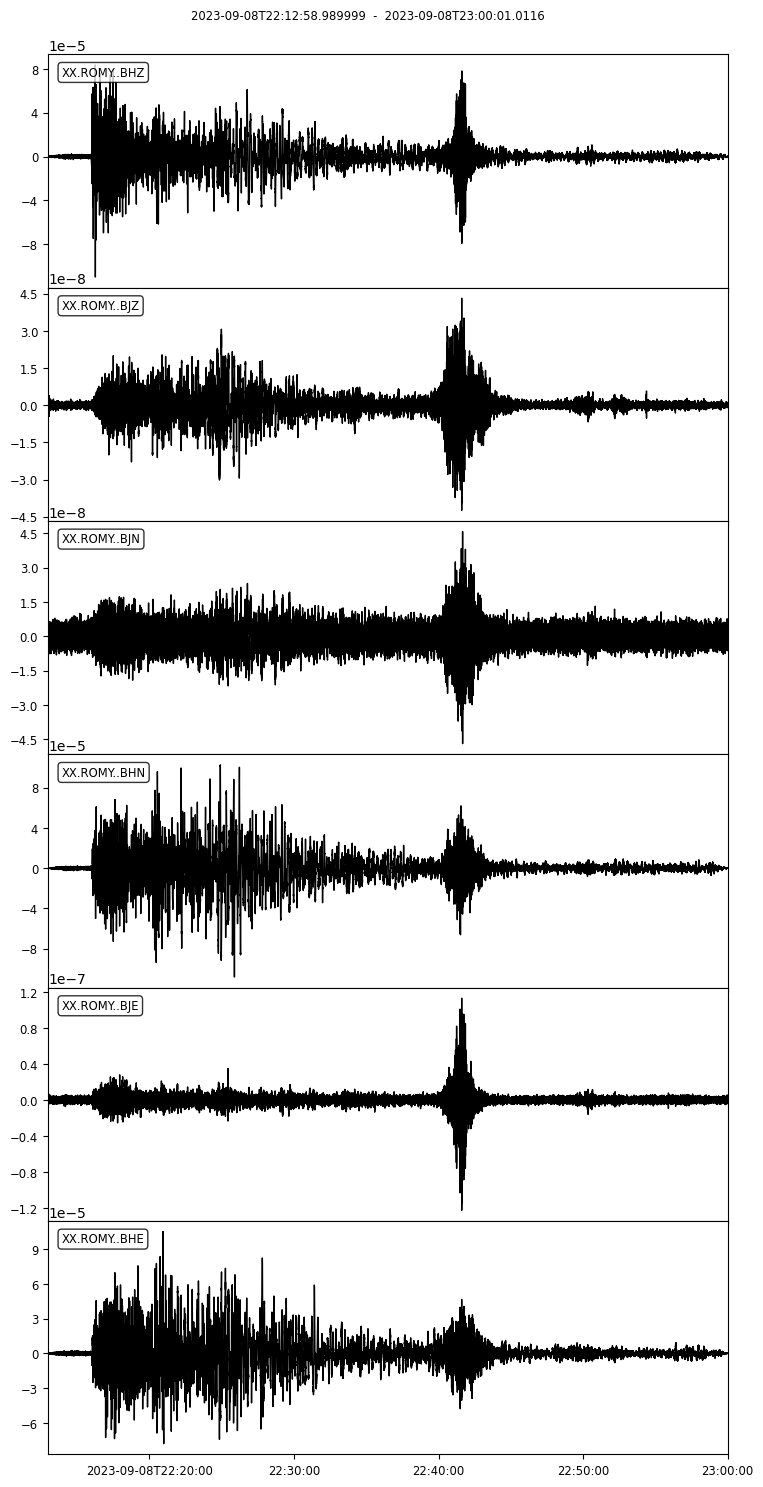

In [6]:
sd.st.plot(equal_scale=False);

In [7]:
sd.trim_stream(set_common=True, set_interpolate=False)

 -> stream size inconsistent: [56441, 56441, 56441, 56441, 56441, 56440]
  -> adjusted: [56440, 56440, 56440, 56440, 56440, 56440]


## Analysis

Define parameters

In [8]:
params = {
    # Filter parameters
    'fmin': 0.02,
    'fmax': 0.2,

    # Backazimuth calculation parameters
    'baz_step': 1, # Step size for backazimuth search in degrees
    'twin_overlap': 0.5, # Window overlap in seconds
    'twin_factor': 6, # Window factor

    # Cross-correlation parameters
    'cc_threshold': 0.75, # Cross-correlation threshold
}


Compute central frequency and optimal time window length

In [9]:
# get optimal time window
params['fc'] = ((params['fmax'] - params['fmin']) + params['fmin']) /2

print(f"fc: {params['fc']}, Twin: {1/params['fc']}, Twin': {int(1/params['fc'])}")

params['twin_sec'] = round(params['twin_factor']/params['fc'], 1)


fc: 0.1, Twin: 10.0, Twin': 10


Frequency band to filter (this is applied to the stream object after being reset to raw stream)

In [10]:
sd.filter_data(fmin=0.05, fmax=0.2, output=False)


Apply polarity correction if needed. This is applied to the stream object that is processed. If raw is True, the polarity correction is applied to the raw stream too.

In [11]:
sd.polarity_stream(pol_dict={"HZ": -1, "JZ": 1}, raw=True)

let's compare the waveforms of the rotation (red) and translational (black) components 

In [12]:
# sd.st.trim(sd.tbeg+90, sd.tend-400) #turkyie
# sd.st.trim(sd.tbeg+200, sd.tend-300) #greek

In [13]:
sd.trim(UTCDateTime(config['tbeg'])+100, UTCDateTime(config['tend'])-1000)

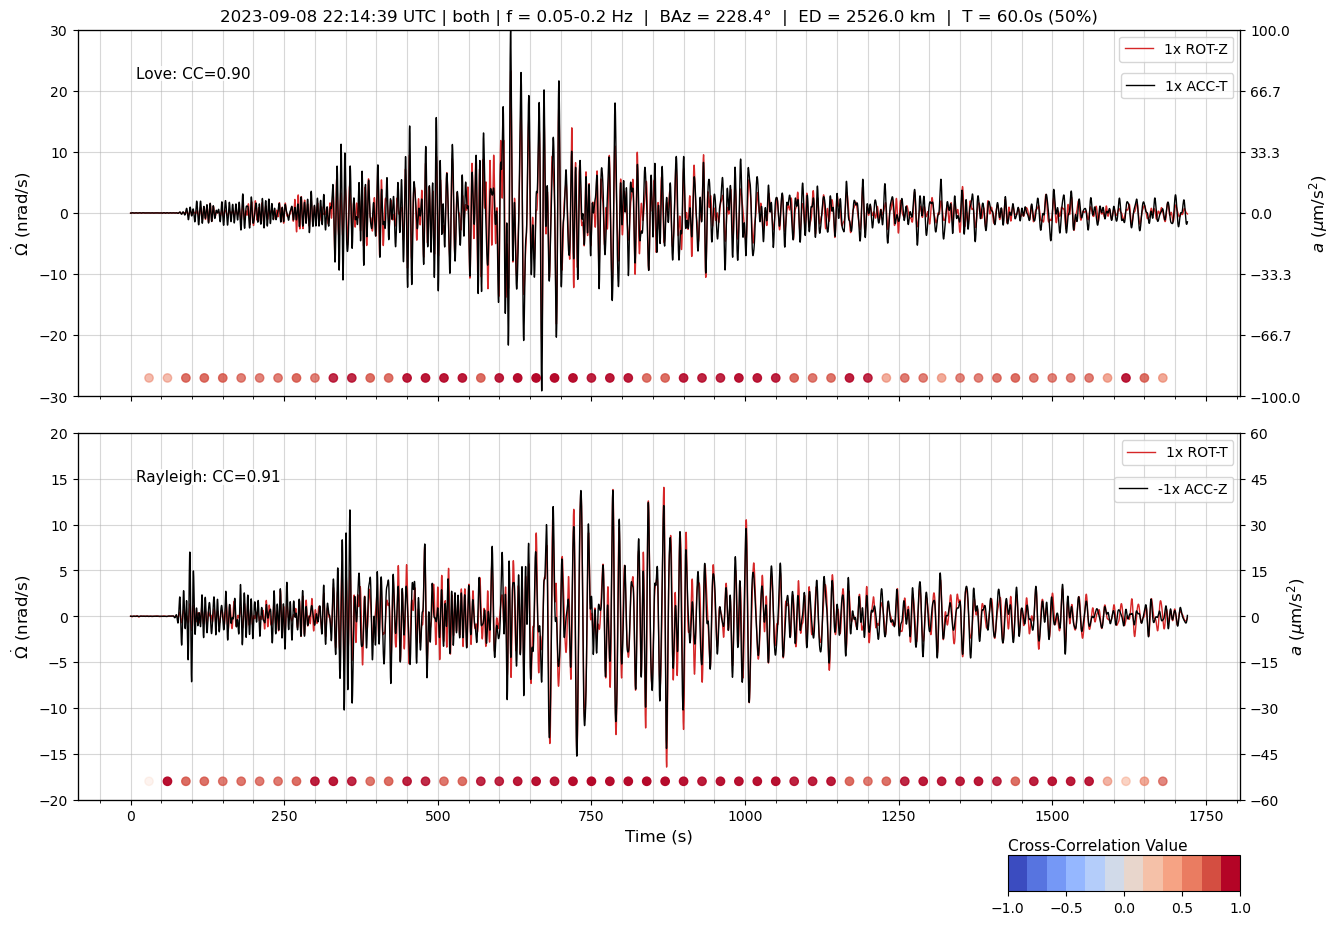

In [14]:
fig = sd.plot_waveform_cc(
    twin_sec=params['twin_sec'],
    twin_overlap=params['twin_overlap'],
    wave_type="both"
)


### Backazimuth Estimate

baz_max = 248, baz_std = 21


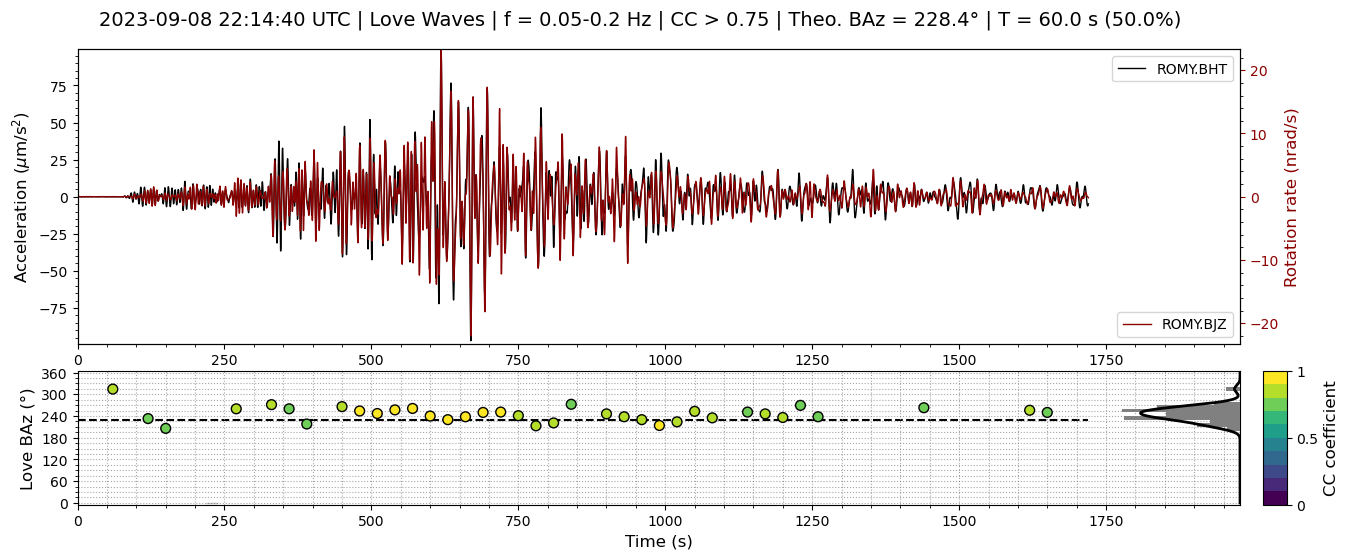

In [19]:
# First compute backazimuth
baz_results = sd.compute_backazimuth(
    wave_type='love',
    baz_step=params['baz_step'],
    baz_win_sec=params['twin_sec'],
    baz_win_overlap=params['twin_overlap'],
    out=True
)

# Then plot results
fig = sd.plot_backazimuth_results(
    baz_results,
    wave_type='love',
    baz_theo=ev['backazimuth'],
    cc_threshold=params['cc_threshold'],  # optional
)

baz_max = 230, baz_std = 9


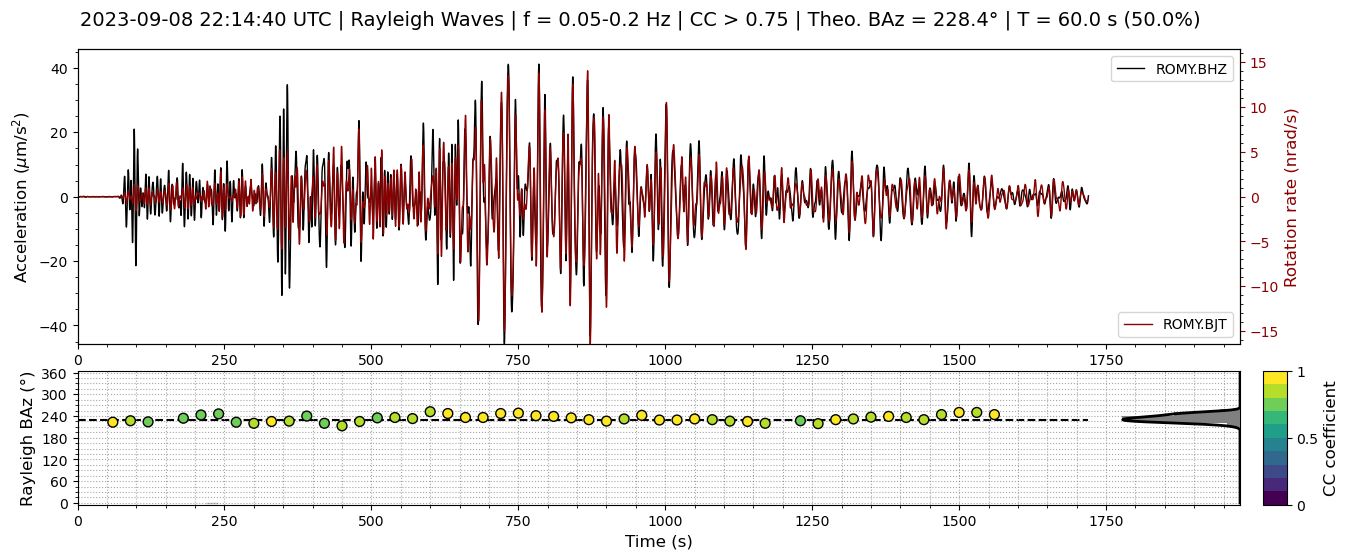

In [20]:
# First compute backazimuth
baz_results = sd.compute_backazimuth(
    wave_type='rayleigh',
    baz_step=params['baz_step'],
    baz_win_sec=params['twin_sec'],
    baz_win_overlap=params['twin_overlap'],
    out=True
)

# # Then plot results
fig = sd.plot_backazimuth_results(
    baz_results,
    wave_type='rayleigh',
    baz_theo=ev['backazimuth'],
    cc_threshold=params['cc_threshold'],  # optional
)

### Compare tangent method

Tangent method for horizontal components of rotations versus acceleration. For acceleration the 180 degrees ambiguitiy remains and is modifed based on the a minimum rmse criterion.

In [17]:
# Original tangent method using rotation components
results_rot = sd.compute_backazimuth(
    wave_type="tangent",
    tangent_components="rotation",
    out=True
)

# New tangent method using acceleration components
results_acc = sd.compute_backazimuth(
    wave_type="tangent",
    tangent_components="acceleration",
    out=True
)

In [23]:
def plot_tangent_method_comparison(results_rot, results_acc, event_info=None, figsize=(12, 6)):
    """
    Simple comparison plot of rotation vs acceleration tangent methods
    
    Parameters:
    -----------
    results_rot : dict
        Results from tangent method using rotation components
    results_acc : dict  
        Results from tangent method using acceleration components
    event_info : dict, optional
        Event information with theoretical backazimuth
    figsize : tuple
        Figure size (width, height)
        
    Returns:
    --------
    matplotlib.figure.Figure
        Simple comparison plot figure
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy import stats
    
    # Extract data
    baz_rot = results_rot['cc_max_y'] 
    cc_rot = results_rot['cc_max']
    
    baz_acc = results_acc['cc_max_y']
    cc_acc = results_acc['cc_max']
    
    # Create single plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create bins every 10 degrees
    bins = np.arange(0, 361, 10)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_width = 10
    
    # Plot histograms with offset positioning
    bar_width = bin_width * 0.35
    
    # Rotation histogram (left side of bins)
    counts_rot, _ = np.histogram(baz_rot, bins=bins, density=True)
    ax.bar(bin_centers - bar_width/2, counts_rot, width=bar_width, 
           alpha=0.6, color='blue', edgecolor='darkblue', linewidth=0.5,
           label=f'Rotation (N={len(baz_rot)})')
    
    # Acceleration histogram (right side of bins)
    counts_acc, _ = np.histogram(baz_acc, bins=bins, density=True)
    ax.bar(bin_centers + bar_width/2, counts_acc, width=bar_width, 
           alpha=0.6, color='red', edgecolor='darkred', linewidth=0.5,
           label=f'Acceleration (N={len(baz_acc)})')
    
    # Add KDE curves
    if len(baz_rot) > 1:
        kde_rot = stats.gaussian_kde(baz_rot, weights=cc_rot)
        x_kde = np.linspace(0, 360, 360)
        kde_values_rot = kde_rot(x_kde)
        ax.plot(x_kde, kde_values_rot, color='darkblue', linewidth=2.5, 
                alpha=0.9, label='Rotation KDE')
    
    if len(baz_acc) > 1:
        kde_acc = stats.gaussian_kde(baz_acc, weights=cc_acc)
        x_kde = np.linspace(0, 360, 360)
        kde_values_acc = kde_acc(x_kde)
        ax.plot(x_kde, kde_values_acc, color='darkred', linewidth=2.5, 
                alpha=0.9, label='Acceleration KDE')
    
    # Add theoretical backazimuth if available
    if event_info and 'backazimuth' in event_info:
        theo_baz = event_info['backazimuth']
        ax.axvline(theo_baz, color='green', linestyle='--', 
                   linewidth=3, label=f'Theoretical: {theo_baz:.1f}°')
    
    # Calculate and display statistics

    # calculated maximum of kde and its index and the half width at half maximum
    kde_rot = stats.gaussian_kde(baz_rot, weights=cc_rot)
    kde_acc = stats.gaussian_kde(baz_acc, weights=cc_acc)
    max_rot = np.max(kde_rot.pdf(x_kde))
    max_rot_index = np.where(kde_rot.pdf(x_kde) == max_rot)[0][0]
    max_acc = np.max(kde_acc.pdf(x_kde))
    max_acc_index = np.where(kde_acc.pdf(x_kde) == max_acc)[0][0]
    hwhm_rot = np.abs(x_kde[np.where(kde_rot.pdf(x_kde) > max_rot/2)[0][0]] - x_kde[np.where(kde_rot.pdf(x_kde) > max_rot/2)[0][-1]])
    hwhm_acc = np.abs(x_kde[np.where(kde_acc.pdf(x_kde) > max_acc/2)[0][0]] - x_kde[np.where(kde_acc.pdf(x_kde) > max_acc/2)[0][-1]])
    
    # Add statistics text
    stats_text = f"Rotation: {max_rot_index:.1f}° ± {hwhm_rot:.1f}°\n"
    stats_text += f"Acceleration: {max_acc_index:.1f}° ± {hwhm_acc:.1f}°\n"
    
    # Calculate difference
    diff = abs(max_rot_index - max_acc_index)
    if diff > 180:
        diff = 360 - diff
    stats_text += f"Difference: {diff:.1f}°"
    
    # Add deviations if theoretical available
    if event_info and 'backazimuth' in event_info:
        dev_rot = abs(max_rot_index - theo_baz)
        if dev_rot > 180:
            dev_rot = 360 - dev_rot
        dev_acc = abs(max_acc_index - theo_baz)
        if dev_acc > 180:
            dev_acc = 360 - dev_acc
        stats_text += f"\nRot. Dev.: {dev_rot:.1f}°\nAcc. Dev.: {dev_acc:.1f}°"
    
    # add max_rot and max_acc as vertical lines between 0 and max value
    ax.plot([max_rot_index, max_rot_index], [0, max_rot],
            color='darkblue', linestyle='--', linewidth=2,
            label=f'Rotation Max: {max_rot_index:.1f}°'
            )
    ax.plot([max_acc_index, max_acc_index], [0, max_acc],
            color='darkred', linestyle='--', linewidth=2,
            label=f'Acceleration Max: {max_acc_index:.1f}°'
            )

    # Position statistics text
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
            verticalalignment='top', fontsize=11, fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='gray'))
    
    # Configure plot
    ax.set_xlabel('Backazimuth (°)', fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.set_title('Tangent Method Comparison: Rotation vs Acceleration Components', 
                 fontsize=14, fontweight='bold')
    ax.set_xlim(0, 360)
    ax.set_xticks([0, 90, 180, 270, 360])
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Remove 0.00 tick label from density axis
    yticks = ax.get_yticks()
    yticks_filtered = yticks[yticks > 0.001]
    if len(yticks_filtered) > 0:
        ax.set_yticks(yticks_filtered)
    
    plt.tight_layout()
    return fig

In [24]:
from sixdegrees.plots.plot_tangent_method_comparison import plot_tangent_method_comparison

KeyError: 'baz_estimate'

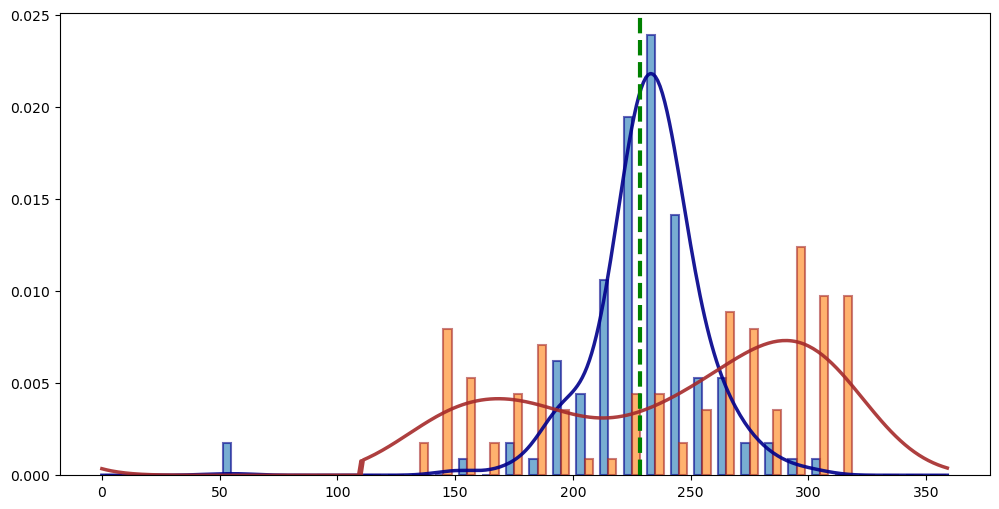

In [25]:
fig = plot_tangent_method_comparison(results_rot, results_acc, event_info=ev)

### Plot Backazimuth Estimation on Map

In [20]:
results_map = sd.compute_backazimuth_map(
    wave_types=['love', 'rayleigh','tangent'],
    baz_win_sec=params['twin_sec'],
    baz_win_overlap=params['twin_overlap'],
    cc_threshold=params['cc_threshold'],
)

Computing love wave backazimuth...
Computing rayleigh wave backazimuth...
Using precomputed tangent backazimuth results


ERROR plotting theoretical great circle: Format specifier missing precision


/home/andbro/cursorfiles/sixdegrees/sixdegrees/plots/plot_backazimuth_map.py:564: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


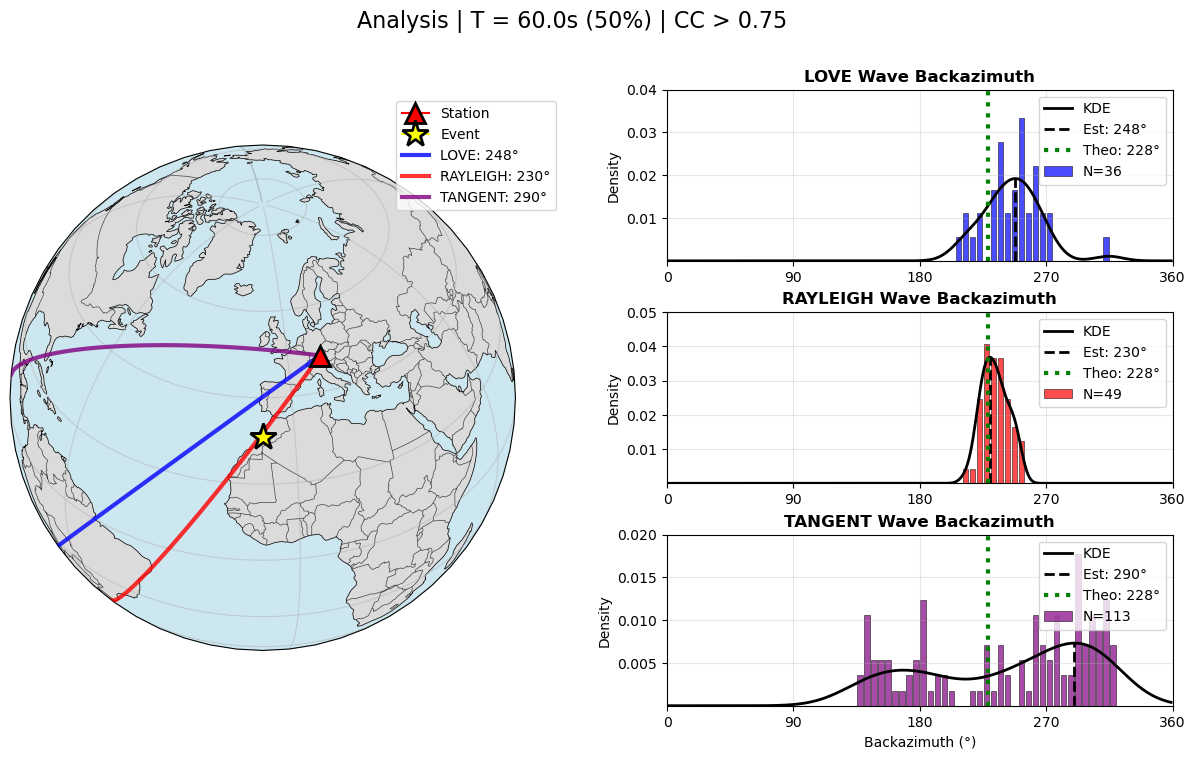

In [22]:
fig = plot_backazimuth_map(
    results_map,
    event_info=ev,
    map_projection='orthographic',  # 'orthographic' or 'platecarree'
)

# fig.savefig(f"./figures/{config['origin_time']}_backazimuth_map.png")

### Compute and Visualize Adaptive Time Windows and Frequency Bands

In [158]:
def compute_frequency_backazimuth_adaptive(sd_object, wave_type='love', fmin=0.01, fmax=0.5, 
                                          octave_fraction=3, baz_step=1, 
                                          window_factor=1.0, overlap_fraction=0.5,
                                          baz_win_sec_overlap=0.5, n_jobs=-1, verbose=True):
    """
    Compute backazimuth for octave frequency bands with adaptive time windows (1/fc)
    
    Parameters:
    -----------
    sd_object : sixdegrees object
    wave_type : str
        'love', 'rayleigh', or 'tangent'
    fmin, fmax : float
        Frequency range in Hz
    octave_fraction : int
        Octave fraction (3 for 1/3 octave)
    window_factor : float
        Multiplier for 1/fc to determine time window length (default: 1.0)
    overlap_fraction : float
        Overlap fraction between time windows (0-1)
    Other parameters passed to compute_backazimuth
    
    Returns:
    --------
    dict : Results with frequency bands, adaptive time windows, correlations, backazimuths
    """
    import numpy as np
    from acoustics.octave import Octave
    from obspy import Stream
    
    if verbose:
        print(f"Computing {wave_type} backazimuth with adaptive time windows (factor={window_factor})...")
    
    # Generate octave bands
    octave = Octave(fraction=octave_fraction, fmin=fmin, fmax=fmax)
    center_freqs = octave.center
    lower_freqs = octave.lower
    upper_freqs = octave.upper
    
    # Store original stream
    original_stream = sd_object.get_stream('all', raw=True).copy()
    total_duration = original_stream[0].stats.endtime - original_stream[0].stats.starttime
    
    # Initialize results
    results = {
        'frequency_bands': center_freqs,
        'frequency_lower': lower_freqs,
        'frequency_upper': upper_freqs,
        'backazimuth_data': [],
        'correlation_data': [],
        'time_windows': [],  # Will be list of arrays, one per frequency
        'adaptive_windows': True,
        'window_factor': window_factor
    }
    
    # Process each frequency band with adaptive time windows
    for i, (fl, fu, fc) in enumerate(zip(lower_freqs, upper_freqs, center_freqs)):
        # Calculate adaptive time window length
        time_window_sec = max(int(window_factor / fc), 1)
   
        if verbose:
            print(f" {i+1}/{len(center_freqs)}: Processing {fc:.3f} Hz ({fl:.3f}-{fu:.3f} Hz), window={time_window_sec:.1f}s")
        
        try:
            # Filter data for this frequency band
            filtered_stream = original_stream.copy()
            filtered_stream.filter('bandpass', freqmin=fl, freqmax=fu, corners=4, zerophase=True)
            
            # Temporarily replace stream in sd_object
            sd_object.st = filtered_stream
            
            # Compute backazimuth for this frequency band with adaptive window
            result = sd_object.compute_backazimuth(
                wave_type=wave_type,
                baz_step=baz_step,
                baz_win_sec=time_window_sec,
                baz_win_sec_overlap=overlap_fraction,
                verbose=False,
                out=True
            )
            
            if result and 'cc_max_y' in result:
                # Store time windows for this frequency
                results['time_windows'].append(result['cc_max_t'])
                
                # Store backazimuth and correlation data
                results['backazimuth_data'].append(result['cc_max_y'])
                results['correlation_data'].append(result['cc_max'])
            else:
                # Fill with NaN if no results
                # Create dummy time windows based on expected length
                n_windows = max(1, int(total_duration / time_window_sec * (1 - overlap_fraction) + 1))
                dummy_times = np.linspace(time_window_sec/2, total_duration - time_window_sec/2, n_windows)
                
                results['time_windows'].append(dummy_times)
                results['backazimuth_data'].append(np.full(len(dummy_times), np.nan))
                results['correlation_data'].append(np.full(len(dummy_times), np.nan))
                
        except Exception as e:
            if verbose:
                print(f"    Error processing {fc:.3f} Hz: {e}")
            
            # Create dummy data for failed processing
            time_window_sec = window_factor / fc
            n_windows = max(1, int(total_duration / time_window_sec * (1 - overlap_fraction) + 1))
            dummy_times = np.linspace(time_window_sec/2, total_duration - time_window_sec/2, n_windows)
            
            results['time_windows'].append(dummy_times)
            results['backazimuth_data'].append(np.full(len(dummy_times), np.nan))
            results['correlation_data'].append(np.full(len(dummy_times), np.nan))
        
        finally:
            # Restore original stream
            sd_object.st = original_stream
    
    if verbose:
        total_points = sum(len(baz_data) for baz_data in results['backazimuth_data'])
        valid_points = sum(np.sum(~np.isnan(baz_data)) for baz_data in results['backazimuth_data'])
        coverage = valid_points / total_points * 100 if total_points > 0 else 0
        print(f"Completed: {coverage:.1f}% coverage ({valid_points}/{total_points} points)")
    
    return results

In [153]:
# Compute with adaptive time windows (1/fc)
results_adaptive = compute_frequency_backazimuth_adaptive(
    sd,
    wave_type='love',
    fmin=0.01,
    fmax=0.8,
    octave_fraction=3,
    window_factor=4.0,  # Use 1.0/fc for time window length
    overlap_fraction=0.5,
)

Computing love backazimuth with adaptive time windows (factor=6.0)...
 1/20: Processing 0.010 Hz (0.009-0.011 Hz), window=600.0s
 2/20: Processing 0.013 Hz (0.011-0.014 Hz), window=476.0s
 3/20: Processing 0.016 Hz (0.014-0.018 Hz), window=378.0s
 4/20: Processing 0.020 Hz (0.018-0.022 Hz), window=300.0s
 5/20: Processing 0.025 Hz (0.022-0.028 Hz), window=238.0s
 6/20: Processing 0.032 Hz (0.028-0.035 Hz), window=189.0s
 7/20: Processing 0.040 Hz (0.035-0.045 Hz), window=150.0s
 8/20: Processing 0.050 Hz (0.045-0.056 Hz), window=119.0s
 9/20: Processing 0.063 Hz (0.056-0.071 Hz), window=95.0s
 10/20: Processing 0.079 Hz (0.071-0.089 Hz), window=75.0s
 11/20: Processing 0.100 Hz (0.089-0.112 Hz), window=59.0s
 12/20: Processing 0.126 Hz (0.112-0.141 Hz), window=47.0s
 13/20: Processing 0.158 Hz (0.141-0.178 Hz), window=37.0s
 14/20: Processing 0.200 Hz (0.178-0.224 Hz), window=30.0s
 15/20: Processing 0.251 Hz (0.224-0.282 Hz), window=23.0s
 16/20: Processing 0.316 Hz (0.282-0.355 Hz), 

In [154]:
def plot_frequency_time_map_adaptive(results, plot_type='backazimuth', event_info=None, 
                                   figsize=(12, 8), vmin=None, vmax=None, colorbar_step=None):
    """
    Plot frequency vs time map for adaptive time windows using grid-based approach
    
    Parameters:
    -----------
    results : dict
        Results from compute_frequency_backazimuth_adaptive
    plot_type : str
        'backazimuth' (shows deviation from theoretical) or 'correlation'
    event_info : dict, optional
        Event info with theoretical 'backazimuth' for comparison
    figsize : tuple
        Figure size
    vmin, vmax : float, optional
        Color scale limits
    colorbar_step : float, optional
        If provided, creates a discrete colorbar with the specified step size
    
    Returns:
    --------
    matplotlib.figure.Figure
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.colors import BoundaryNorm
    
    # Check if this is adaptive window data
    if not results.get('adaptive_windows', False):
        print("Warning: This function is designed for adaptive window results")
    
    
    freq_bands = results['frequency_bands']
    
    # Find the smallest time window to determine grid resolution
    min_window_length = float('inf')
    all_times = []
    
    for freq_idx, freq in enumerate(freq_bands):
        time_windows = results['time_windows'][freq_idx]
        all_times.extend(time_windows)
        
        # Calculate window length for this frequency
        window_length = results['window_factor'] / freq
        min_window_length = min(min_window_length, window_length)
    
    # Create time grid based on smallest window
    all_times = np.array(all_times)
    time_min, time_max = np.min(all_times), np.max(all_times)
    
    # Grid resolution: use half the minimum window length for fine resolution
    grid_time_step = min_window_length / 2
    n_time_bins = int((time_max - time_min) / grid_time_step) + 1
    time_grid = np.linspace(time_min, time_max, n_time_bins)
    
    # Create frequency grid (log scale)
    freq_grid = freq_bands
    
    # Create meshgrid
    TIME_GRID, FREQ_GRID = np.meshgrid(time_grid, freq_grid)
    
    # Initialize data grid with NaN
    data_grid = np.full(TIME_GRID.shape, np.nan)
    
    # Fill grid with data from each frequency band
    for freq_idx, freq in enumerate(freq_bands):
        time_windows = results['time_windows'][freq_idx]
        
        if plot_type == 'backazimuth':
            baz_data = results['backazimuth_data'][freq_idx]
            
            if event_info and 'backazimuth' in event_info:
                theoretical_baz = event_info['backazimuth']
                # Calculate deviation
                deviation = baz_data - theoretical_baz
                deviation = ((deviation + 180) % 360) - 180
                values = deviation
            else:
                values = baz_data
        else:  # correlation
            values = results['correlation_data'][freq_idx]
        
        # Ensure arrays have same length
        min_length = min(len(time_windows), len(values))
        time_windows_trimmed = time_windows[:min_length]
        values_trimmed = values[:min_length]
        
        # Calculate window length for this frequency
        window_length = results['window_factor'] / freq
        half_window = window_length / 2
        
        # Fill grid cells for each time window
        for t_center, value in zip(time_windows_trimmed, values_trimmed):
            if np.isnan(value):
                continue
                
            # Find time range for this window
            t_start = t_center - half_window
            t_end = t_center + half_window
            
            # Find grid indices that fall within this time window
            time_mask = (time_grid >= t_start) & (time_grid <= t_end)
            time_indices = np.where(time_mask)[0]
            
            # Fill all grid cells within this time window
            for t_idx in time_indices:
                data_grid[freq_idx, t_idx] = value
    
   # Set up plot parameters
    if plot_type == 'backazimuth':
        if event_info and 'backazimuth' in event_info:
            label = 'Backazimuth Deviation (°)'
            cmap = plt.get_cmap('RdBu_r')
            if vmin is None and vmax is None:
                valid_data = data_grid[~np.isnan(data_grid)]
                vmin, vmax = -180, 180
        else:
            label = 'Backazimuth (°)'
            cmap = plt.get_cmap('hsv')
            if vmin is None: vmin = -180
            if vmax is None: vmax = 180
    else:
        label = 'Cross-Correlation'
        cmap = plt.get_cmap('viridis')
        if vmin is None: vmin = 0
        if vmax is None: 
            valid_data = data_grid[~np.isnan(data_grid)]
            vmax = np.max(valid_data) if len(valid_data) > 0 else 1.0
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Handle discrete colorbar if step size is provided
    if colorbar_step is not None:
        # Create boundaries for discrete colors
        boundaries = np.arange(vmin, vmax + colorbar_step, colorbar_step)
        norm = BoundaryNorm(boundaries, cmap.N)
        
        # Plot heatmap using pcolormesh with discrete colors
        im = ax.pcolormesh(time_grid, freq_bands, data_grid, 
                          cmap=cmap, norm=norm, shading='auto')
        
        # Add colorbar with discrete ticks
        cbar = plt.colorbar(im, ax=ax, label=label, 
                           boundaries=boundaries,
                           ticks=boundaries, pad=0.02)
    else:
        # Original continuous colorbar
        im = ax.pcolormesh(time_grid, freq_bands, data_grid, 
                          cmap=cmap, vmin=vmin, vmax=vmax, shading='auto')
        cbar = plt.colorbar(im, ax=ax, label=label)

    # Show adaptive window boundaries
    try:
        for freq_idx, freq in enumerate(freq_bands):
            time_windows = results['time_windows'][freq_idx]
            window_length = results['window_factor'] / freq
            
            # Plot window boundaries as horizontal lines
            # for t in time_windows:
            #     # Draw window extent
            #     ax.plot([t - window_length/2, t + window_length/2], [freq, freq], 
            #            'k-', alpha=0.4, linewidth=1)
            #     # Mark window center
            #     ax.plot([t, t], [freq * 0.95, freq * 1.05], 'k-', alpha=0.6, linewidth=1)
    except Exception as e:
        print(f"Warning: Could not plot window boundaries: {e}")
    
    # Formatting
    ax.set_xlabel('Time (s)', fontsize=12)
    ax.set_ylabel('Frequency (Hz)', fontsize=12)
    ax.set_yscale('log')
    
    title = f'Frequency-Time Map: {plot_type.title()} (Adaptive Windows: {results["window_factor"]:.1f}/fc)'
    if plot_type == 'backazimuth' and event_info and 'backazimuth' in event_info:
        title += f'\n(Theoretical BAZ: {event_info["backazimuth"]:.1f}°)'
    
    ax.set_title(title, fontsize=14)
    # ax.grid(True, alpha=0.3)
    
    # Calculate statistics
    all_valid_values = data_grid[~np.isnan(data_grid)]

    
    plt.tight_layout()
    return fig

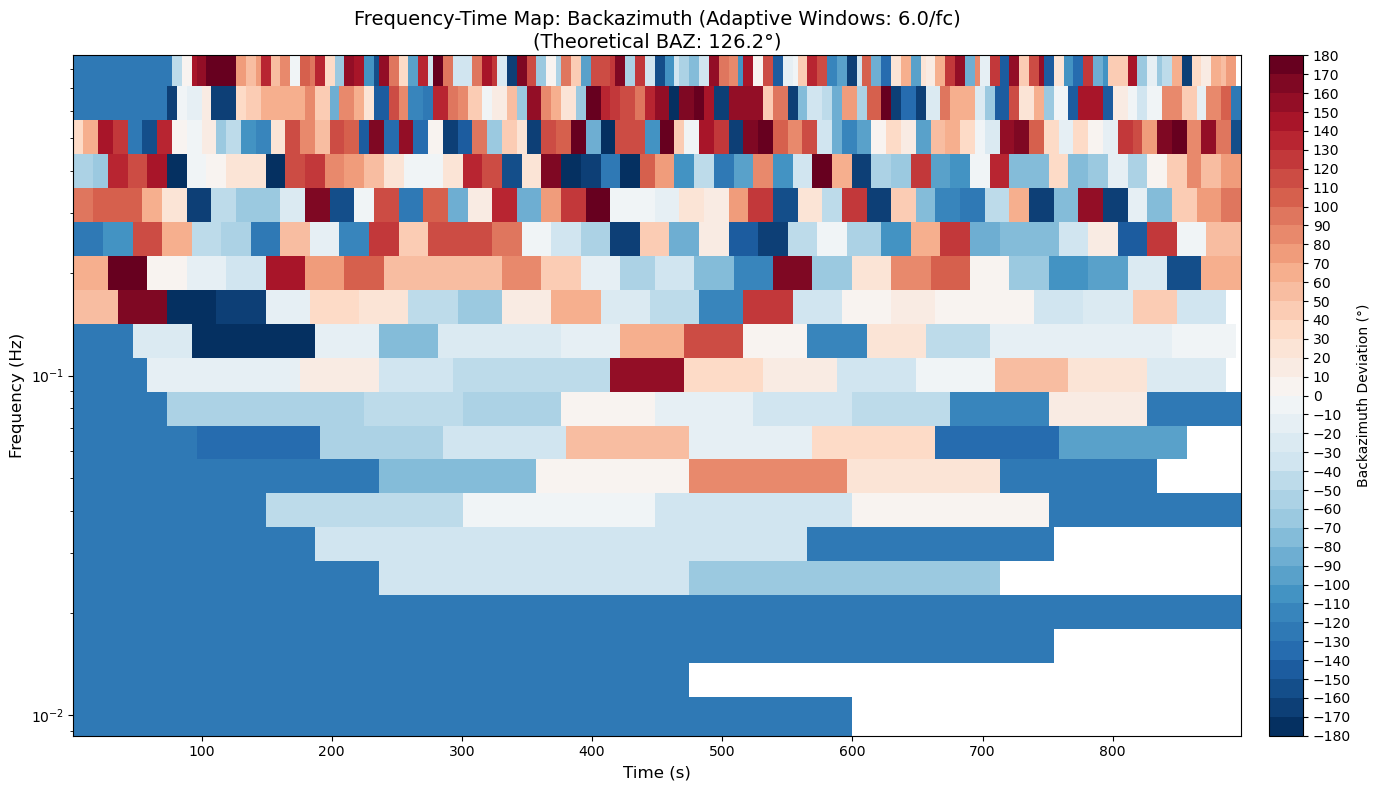

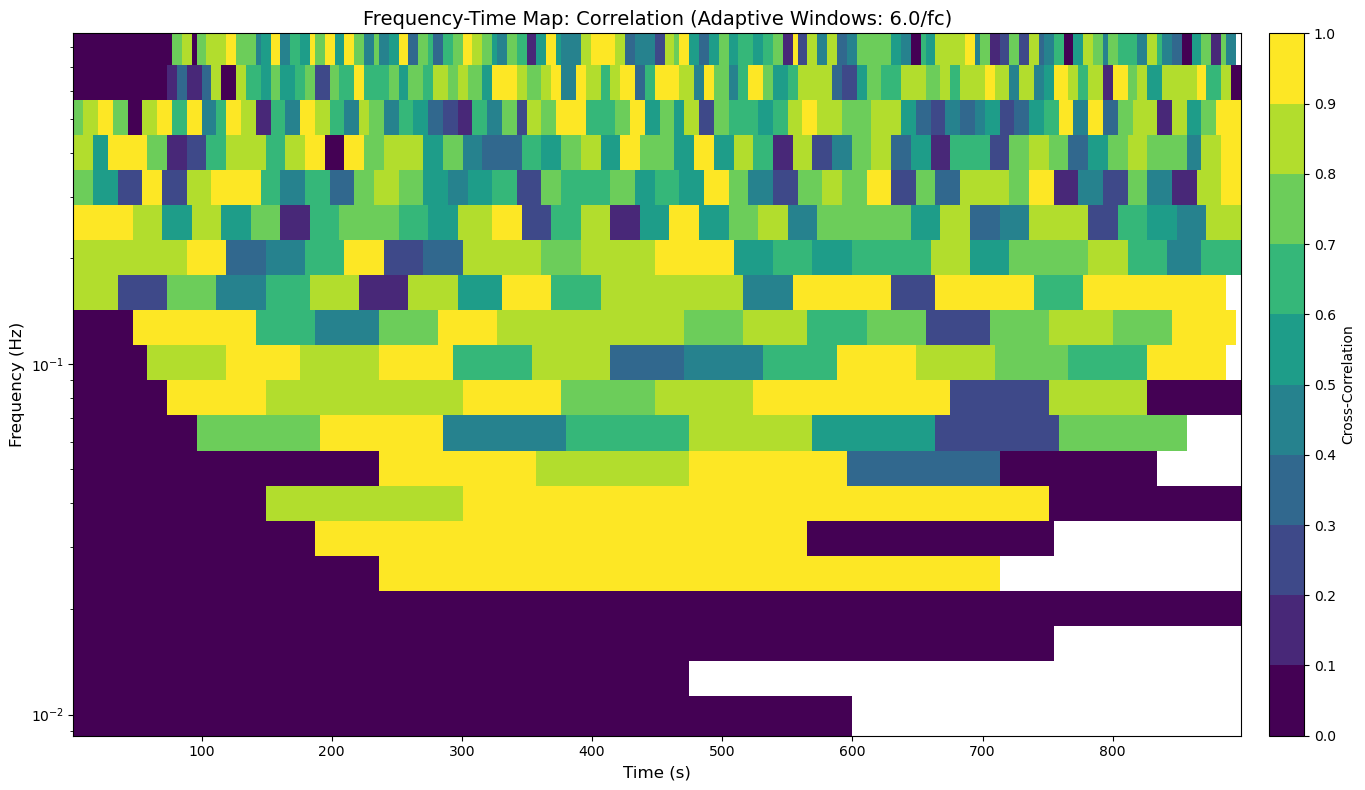

In [155]:

# Plot backazimuth deviation map with adaptive windows
fig1 = plot_frequency_time_map_adaptive(
    results_adaptive, 
    plot_type='backazimuth',
    event_info=ev,
    colorbar_step=10,
    figsize=(15, 8)
)

# Plot correlation map with adaptive windows
fig2 = plot_frequency_time_map_adaptive(
    results_adaptive,
    colorbar_step=0.1,
    plot_type='correlation',
    figsize=(15, 8)
)


In [156]:
def compute_distribution(self, results_adaptive, weight_by_cc=True, plot=False, 
                                   baz_theo=None, bins=36, bw_method='scott', cc_threshold=0.0):
    """
    Compute histogram and KDE of backazimuth estimates from adaptive frequency-time analysis.
    
    Parameters:
    -----------
    results_adaptive : dict
        Results from compute_frequency_backazimuth_adaptive
    weight_by_cc : bool, optional
        Whether to weight the estimates by their correlation coefficient (default: True)
    plot : bool, optional
        Whether to plot the histogram and KDE (default: False)
    baz_theo : float, optional
        Theoretical backazimuth for reference in plot
    bins : int, optional
        Number of bins for histogram (default: 36, i.e., 10° bins)
    bw_method : str or float, optional
        Bandwidth method for KDE estimation (default: 'scott')
    cc_threshold : float, optional
        Minimum correlation coefficient to include in analysis (default: 0.0)
        
    Returns:
    --------
    dict
        Dictionary containing:
        - 'kde_max': Backazimuth at maximum of KDE
        - 'hwhm': Half width at half maximum of KDE
        - 'hist': Histogram counts
        - 'bin_edges': Histogram bin edges
        - 'kde': KDE function object
        - 'baz_grid': Grid points where KDE was evaluated
        - 'kde_values': KDE values at grid points
        - 'figure': matplotlib figure if plot=True
        - 'n_estimates': Number of estimates used after filtering
    """
    import numpy as np
    from scipy import stats
    import matplotlib.pyplot as plt
    
    # Collect all backazimuth estimates and correlation coefficients
    baz_values = []
    cc_values = []
    
    # Extract values from all frequency bands
    for freq_idx in range(len(results_adaptive['frequency_bands'])):
        baz_data = results_adaptive['backazimuth_data'][freq_idx]
        cc_data = results_adaptive['correlation_data'][freq_idx]
        
        # Remove NaN values and apply CC threshold
        mask = (~np.isnan(baz_data) & ~np.isnan(cc_data) & (cc_data >= cc_threshold))
        baz_values.extend(baz_data[mask])
        cc_values.extend(cc_data[mask])
    
    baz_values = np.array(baz_values)
    cc_values = np.array(cc_values)
    
    # Check if we have enough data points after filtering
    if len(baz_values) < 2:
        return {
            'kde_max': None,
            'hwhm': None,
            'hist': None,
            'bin_edges': None,
            'kde': None,
            'baz_grid': None,
            'kde_values': None,
            'figure': None,
            'n_estimates': 0
        }
    
    # Compute weights if requested
    weights = cc_values if weight_by_cc else None
    
    # Compute histogram
    hist, bin_edges = np.histogram(baz_values, bins=bins, weights=weights, 
                                 range=(0, 360), density=True)
    
    # Compute KDE
    kde = stats.gaussian_kde(baz_values, weights=weights, bw_method=bw_method)
    
    # Create fine grid for KDE evaluation
    baz_grid = np.linspace(0, 360, 360)
    kde_values = kde(baz_grid)
    
    # Find maximum of KDE
    kde_max = baz_grid[np.argmax(kde_values)]
    
    # Compute HWHM (Half Width at Half Maximum)
    max_kde = np.max(kde_values)
    half_max = max_kde / 2
    
    # Find points where KDE crosses half maximum
    crosses_half_max = kde_values >= half_max
    ranges = np.where(np.diff(crosses_half_max))[0]
    
    if len(ranges) >= 2:
        # Get the width of the peak
        hwhm = (baz_grid[ranges[1]] - baz_grid[ranges[0]]) / 2
    else:
        hwhm = None
    
    # Create plot if requested
    fig = None
    if plot:
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Plot histogram
        ax.hist(baz_values, bins=bins, weights=weights, density=True, 
                alpha=0.5, label='Histogram')
        
        # Plot KDE
        ax.plot(baz_grid, kde_values, 'k-', lw=2, label='KDE')
        
        # Plot KDE maximum
        ax.plot([kde_max, kde_max], [0, max_kde], color='r', linestyle='--', 
                   label=f'KDE max: {kde_max:.1f}°')
        
        # Plot theoretical backazimuth if provided
        if baz_theo is not None:
            ax.axvline(baz_theo, color='g', linestyle='--', 
                       label=f'Theoretical: {baz_theo:.1f}°')
        
        ax.set_xlabel('Backazimuth (°)')
        ax.set_ylabel('Density')
        title = 'Backazimuth Distribution'
        if weight_by_cc:
            title += ' (CC-weighted'
        if cc_threshold > 0:
            title += f', CC threshold: {cc_threshold:.1f})'
        else:
            title += ')'

        ax.set_title(title)
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, 360)

        plt.tight_layout()
    
    return {
        'kde_max': kde_max,
        'hwhm': hwhm,
        'hist': hist,
        'bin_edges': bin_edges,
        'kde': kde,
        'baz_grid': baz_grid,
        'kde_values': kde_values,
        'figure': fig,
        'n_estimates': len(baz_values)
    }

Most likely backazimuth: 105.3° ± 146.4°


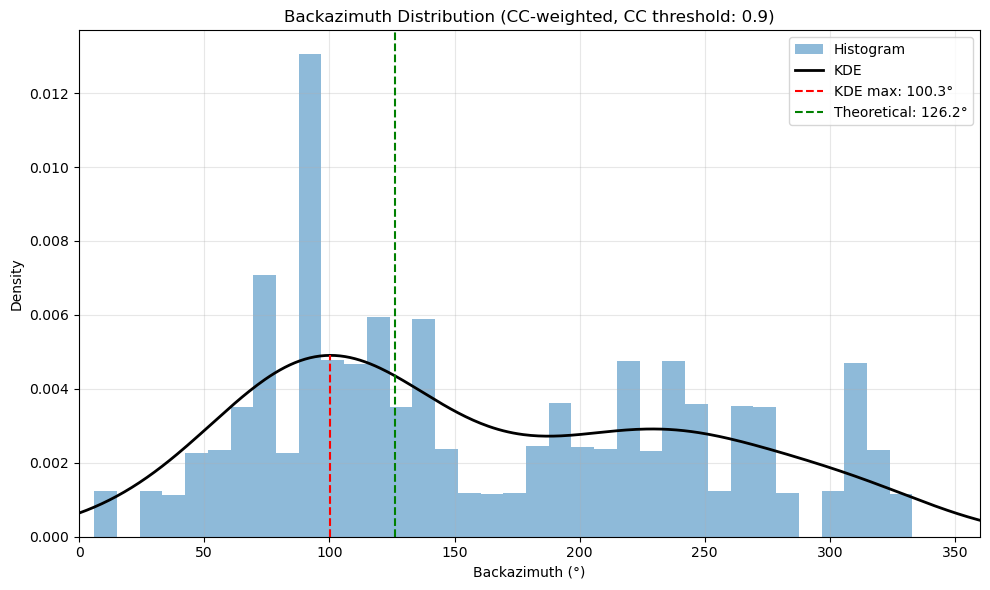

In [160]:
# Basic usage
results = compute_backazimuth_distribution(sd, results_adaptive)
print(f"Most likely backazimuth: {results['kde_max']:.1f}° ± {results['hwhm']:.1f}°")

# With plotting and theoretical comparison
results = compute_backazimuth_distribution(sd,
    results_adaptive,
    weight_by_cc=True,
    cc_threshold=0.9,
    plot=True,
    baz_theo=sd.event_info['backazimuth']
)

### Compute and Plot backazimuth by frequency bands

In [23]:
def compute_frequency_dependent_backazimuth(sd_object, wave_types=['love', 'rayleigh'],
                                          fmin=0.01, fmax=0.5, octave_fraction=3,
                                          baz_step=1, baz_win_sec=None, baz_win_sec_overlap=0.5,
                                          cc_threshold=0.5, baz_grid_step=1):
    """
    Compute backazimuth estimation across different frequency bands using octave filtering
    
    Parameters:
    -----------
    sd_object : sixdegrees object
        The sixdegrees object containing the data
    wave_types : list
        List of wave types to analyze ['love', 'rayleigh']
    fmin : float
        Minimum frequency in Hz
    fmax : float
        Maximum frequency in Hz
    octave_fraction : int
        Octave fraction (e.g., 3 for 1/3 octave bands)
    baz_step : int
        Step size for backazimuth search in degrees
    baz_win_sec : float
        Window length in seconds
    baz_win_sec_overlap : float
        Window overlap fraction
    cc_threshold : float
        Minimum cross-correlation threshold
    baz_grid_step : int
        Step size for backazimuth grid for KDE evaluation
        
    Returns:
    --------
    dict : Results dictionary with frequency bands and KDE data
    """
    import numpy as np
    import scipy.stats as sts
    from acoustics.octave import Octave
    from obspy import Stream
    
    print("Computing frequency-dependent backazimuth analysis...")
    
    # Generate octave bands
    octave = Octave(fraction=octave_fraction, fmin=fmin, fmax=fmax)
    center_freqs = octave.center
    lower_freqs = octave.lower
    upper_freqs = octave.upper
    
    print(f"Generated {len(center_freqs)} frequency bands from {fmin} to {fmax} Hz")
    
    # Backazimuth grid for KDE evaluation
    baz_grid = np.arange(0, 360, baz_grid_step)
    
    # Results storage
    results = {
        'frequency_bands': {
            'center': center_freqs,
            'lower': lower_freqs,
            'upper': upper_freqs
        },
        'baz_grid': baz_grid,
        'wave_types': {},
        'parameters': {
            'octave_fraction': octave_fraction,
            'cc_threshold': cc_threshold,
            'baz_win_sec': baz_win_sec,
            'baz_win_sec_overlap': baz_win_sec_overlap
        }
    }
    
    # Store original stream
    original_stream = sd_object.get_stream('all', raw=True).copy()

    original_fmin = getattr(sd_object, 'fmin', None)
    original_fmax = getattr(sd_object, 'fmax', None)
    
    try:
        for wave_type in wave_types:
            if wave_type not in ['love', 'rayleigh']:
                continue
                
            print(f"\nProcessing {wave_type} waves...")
            results['wave_types'][wave_type] = {
                'kde_values': np.zeros((len(center_freqs), len(baz_grid))),
                'peak_baz': np.full(len(center_freqs), np.nan),
                'mean_baz': np.full(len(center_freqs), np.nan),
                'cc_mean': np.full(len(center_freqs), np.nan),
                'n_estimates': np.zeros(len(center_freqs), dtype=int)
            }
            
            for i, (fc, fl, fu) in enumerate(zip(center_freqs, lower_freqs, upper_freqs)):

                # window seconds
                tmp_baz_win_sec = int(1/fc)
                if baz_win_sec is not None:
                    tmp_baz_win_sec = baz_win_sec

                print(f"  Processing band {i+1}/{len(center_freqs)}: {fl:.3f}-{fu:.3f} Hz (center: {fc:.3f} Hz): Twin = {tmp_baz_win_sec}s")
            
                try:
                    # Reset stream to original
                    sd_object.st = original_stream.copy()
                    
                    # Filter data for this frequency band
                    sd_object.filter_data(fmin=fl, fmax=fu, output=False)
                    
                    # Compute backazimuth for this frequency band
                    baz_result = sd_object.compute_backazimuth(
                        wave_type=wave_type,
                        baz_step=baz_step,
                        baz_win_sec=tmp_baz_win_sec,
                        baz_win_sec_overlap=baz_win_sec_overlap,
                        verbose=False,
                        out=True
                    )
                    
                    # Process results if valid
                    if 'cc_max' in baz_result and len(baz_result['cc_max']) > 0:
                        mask = baz_result['cc_max'] >= cc_threshold
                        
                        if np.any(mask):
                            baz_estimates = baz_result['cc_max_y'][mask]
                            cc_values = baz_result['cc_max'][mask]
                            
                            # Store basic statistics
                            results['wave_types'][wave_type]['n_estimates'][i] = len(baz_estimates)
                            results['wave_types'][wave_type]['cc_mean'][i] = np.mean(cc_values)
                            results['wave_types'][wave_type]['mean_baz'][i] = np.average(baz_estimates, weights=cc_values)
                            
                            # Compute weighted KDE
                            if len(baz_estimates) > 5:
                                kde = sts.gaussian_kde(baz_estimates, weights=cc_values)
                                
                                # Evaluate KDE on grid
                                kde_values = kde.pdf(baz_grid)
                                results['wave_types'][wave_type]['kde_values'][i, :] = kde_values
                                
                                # Find peak
                                peak_idx = np.argmax(kde_values)
                                results['wave_types'][wave_type]['peak_baz'][i] = baz_grid[peak_idx]
                            else:
                                # Single estimate - create delta-like distribution
                                baz_idx = int(np.round(baz_estimates[0] / baz_grid_step)) % len(baz_grid)
                                results['wave_types'][wave_type]['kde_values'][i, baz_idx] = 1.0
                                results['wave_types'][wave_type]['peak_baz'][i] = baz_estimates[0]
                        else:
                            print(f"    No estimates above threshold for {fc:.3f} Hz")
                    else:
                        print(f"    No valid results for {fc:.3f} Hz")
                        
                except Exception as e:
                    print(f"    Error processing {fc:.3f} Hz: {str(e)}")
                    continue
    
    finally:
        # Restore original stream and filter settings
        sd_object.st = original_stream
        if original_fmin is not None:
            sd_object.fmin = original_fmin
        if original_fmax is not None:
            sd_object.fmax = original_fmax
    
    print(f"\nFrequency-dependent backazimuth analysis completed.")
    return results

In [24]:
results_freq = compute_frequency_dependent_backazimuth(
    sd,
    wave_types=['love', 'rayleigh', 'tangent'],
    fmin=0.02,
    fmax=0.5,
    octave_fraction=3,  # 1/3 octave bands
    baz_step=1,
    baz_win_sec=None, # None = 1/fmin
    baz_win_sec_overlap=0.5,
    cc_threshold=0.5,
    baz_grid_step=1
)

Computing frequency-dependent backazimuth analysis...
Generated 15 frequency bands from 0.02 to 0.5 Hz

Processing love waves...
  Processing band 1/15: 0.018-0.022 Hz (center: 0.020 Hz): Twin = 50s
    No estimates above threshold for 0.020 Hz
  Processing band 2/15: 0.022-0.028 Hz (center: 0.025 Hz): Twin = 39s
  Processing band 3/15: 0.028-0.035 Hz (center: 0.032 Hz): Twin = 31s
  Processing band 4/15: 0.035-0.045 Hz (center: 0.040 Hz): Twin = 25s
  Processing band 5/15: 0.045-0.056 Hz (center: 0.050 Hz): Twin = 19s
  Processing band 6/15: 0.056-0.071 Hz (center: 0.063 Hz): Twin = 15s
  Processing band 7/15: 0.071-0.089 Hz (center: 0.079 Hz): Twin = 12s
  Processing band 8/15: 0.089-0.112 Hz (center: 0.100 Hz): Twin = 9s
  Processing band 9/15: 0.112-0.141 Hz (center: 0.126 Hz): Twin = 7s
  Processing band 10/15: 0.141-0.178 Hz (center: 0.158 Hz): Twin = 6s
  Processing band 11/15: 0.178-0.224 Hz (center: 0.200 Hz): Twin = 5s
  Processing band 12/15: 0.224-0.282 Hz (center: 0.251 Hz

KeyboardInterrupt: 

In [26]:
def plot_frequency_backazimuth_analysis(results, event_info=None, vmax_percentile=95,
                                       figsize=(12, 10), show_peak_line=True):
    """
    Plot frequency-dependent backazimuth analysis results
    
    Parameters:
    -----------
    results : dict
        Results from compute_frequency_dependent_backazimuth
    event_info : dict, optional
        Event information with 'backazimuth' key for theoretical comparison
    vmax_percentile : float
        Percentile for color scale maximum (to avoid outliers)
    figsize : tuple
        Figure size (width, height)
    show_peak_line : bool
        Whether to show line connecting peak estimates
        
    Returns:
    --------
    matplotlib.figure.Figure : The created figure
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.colors import LogNorm
    
    wave_types = list(results['wave_types'].keys())
    n_wave_types = len(wave_types)
    
    if n_wave_types == 0:
        print("No wave type results to plot")
        return None
    
    # Create figure
    fig, axes = plt.subplots(n_wave_types, 1, figsize=figsize, sharex=True)
    if n_wave_types == 1:
        axes = [axes]
    
    # Get frequency data
    center_freqs = results['frequency_bands']['center']
    baz_grid = results['baz_grid']
    
    # Create meshgrid for pcolormesh
    freq_edges = np.logspace(np.log10(center_freqs.min()), np.log10(center_freqs.max()), len(center_freqs) + 1)
    baz_edges = np.arange(0, 361, np.diff(baz_grid)[0])
    
    colors = {'love': 'Blues', 'rayleigh': 'Reds'}
    
    for i, wave_type in enumerate(wave_types):
        ax = axes[i]
        data = results['wave_types'][wave_type]
        
        # Get KDE values and normalize for better visualization
        kde_matrix = data['kde_values'].T  # Transpose for correct orientation
        
        # Set colormap limits
        kde_nonzero = kde_matrix[kde_matrix > 0]
        if len(kde_nonzero) > 0:
            vmax = np.percentile(kde_nonzero, vmax_percentile)
            vmin = np.percentile(kde_nonzero, 5)
        else:
            vmax = 1.0
            vmin = 0.01
        
        # Create pcolormesh plot
        colormap = colors.get(wave_type, 'viridis')
        im = ax.pcolormesh(center_freqs, baz_grid, kde_matrix, 
                          cmap=colormap, shading='auto',
                          vmin=vmin, vmax=vmax)
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax, label='KDE Density', pad=0.02)
        
        # Plot peak line if requested
        if show_peak_line:
            valid_peaks = ~np.isnan(data['peak_baz'])
            if np.any(valid_peaks):
                ax.plot(center_freqs[valid_peaks], data['peak_baz'][valid_peaks], 
                       'k-', linewidth=2, alpha=0.8, label='Peak BAZ')
                ax.scatter(center_freqs[valid_peaks], data['peak_baz'][valid_peaks], 
                       color='k', marker='o', alpha=0.8, facecolor='white', zorder=3)
        
        # Plot theoretical backazimuth if available
        if event_info and 'backazimuth' in event_info:
            ax.axhline(y=event_info['backazimuth'], color='grey', 
                      linestyle='--', linewidth=2, alpha=0.9, label='Theoretical BAZ')
        
        # Customize axes
        ax.set_xscale('log')
        ax.set_ylabel('Backazimuth (°)')
        ax.set_ylim(0, 360)
        ax.set_yticks(np.arange(0, 361, 60))
        ax.grid(True, alpha=0.3)
        ax.set_title(f'{wave_type.upper()} Wave Backazimuth vs Frequency', 
                    fontsize=12, fontweight='bold')
        
        # Add legend if there are lines to show
        if show_peak_line or (event_info and 'backazimuth' in event_info):
            ax.legend(loc='upper right')
        
        # Add statistics text
        n_bands_with_data = np.sum(data['n_estimates'] > 0)
        stats_text = f'Bands with data: {n_bands_with_data}/{len(center_freqs)}'
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
               verticalalignment='top', fontsize=10)
    
    # Set x-label only for bottom subplot
    axes[-1].set_xlabel('Frequency (Hz)')
    
    # Main title
    octave_frac = results['parameters']['octave_fraction']
    plt.suptitle(f'Frequency-Dependent Backazimuth Analysis (1/{octave_frac} Octave Bands)', 
                fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    return fig

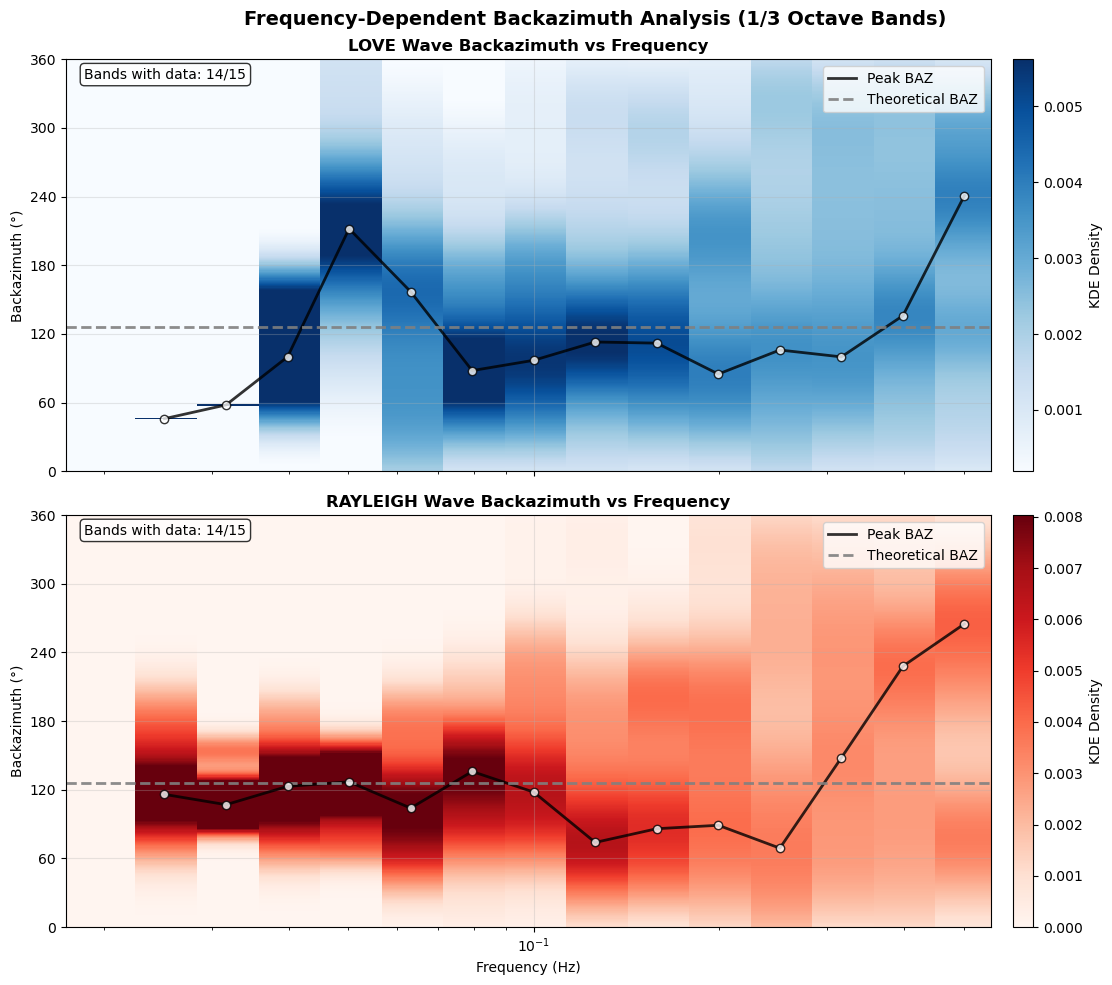

In [27]:
# Plot the results
fig = plot_frequency_backazimuth_analysis(
    results=results_freq,
    event_info=ev,  # Your event information
    vmax_percentile=95,
    figsize=(12, 10),
    show_peak_line=True
)

fig.savefig(f"./figures/{config['origin_time']}_backazimuth_frequency_band_analysis.png")


In [ ]:
# Analyze deviations
fig, deviation_results = plot_backazimuth_deviation_analysis(
    results=results_freq,
    event_info=ev,  # Must contain 'backazimuth' key
    figsize=(15, 8),
    bin_step=10
)

print_deviation_summary(deviation_results)


### OLD STUFF


using love waves for backazimuth estimation ...

Estimated BAZ Love = 105° (CC ≥ 0.1)

using rayleigh waves for backazimuth estimation ...

Estimated BAZ Rayleigh = 127° (CC ≥ 0.1)

using tangent for backazimuth estimation ...

Estimated BAZ Tangent = 133° (CC ≥ 0.1)


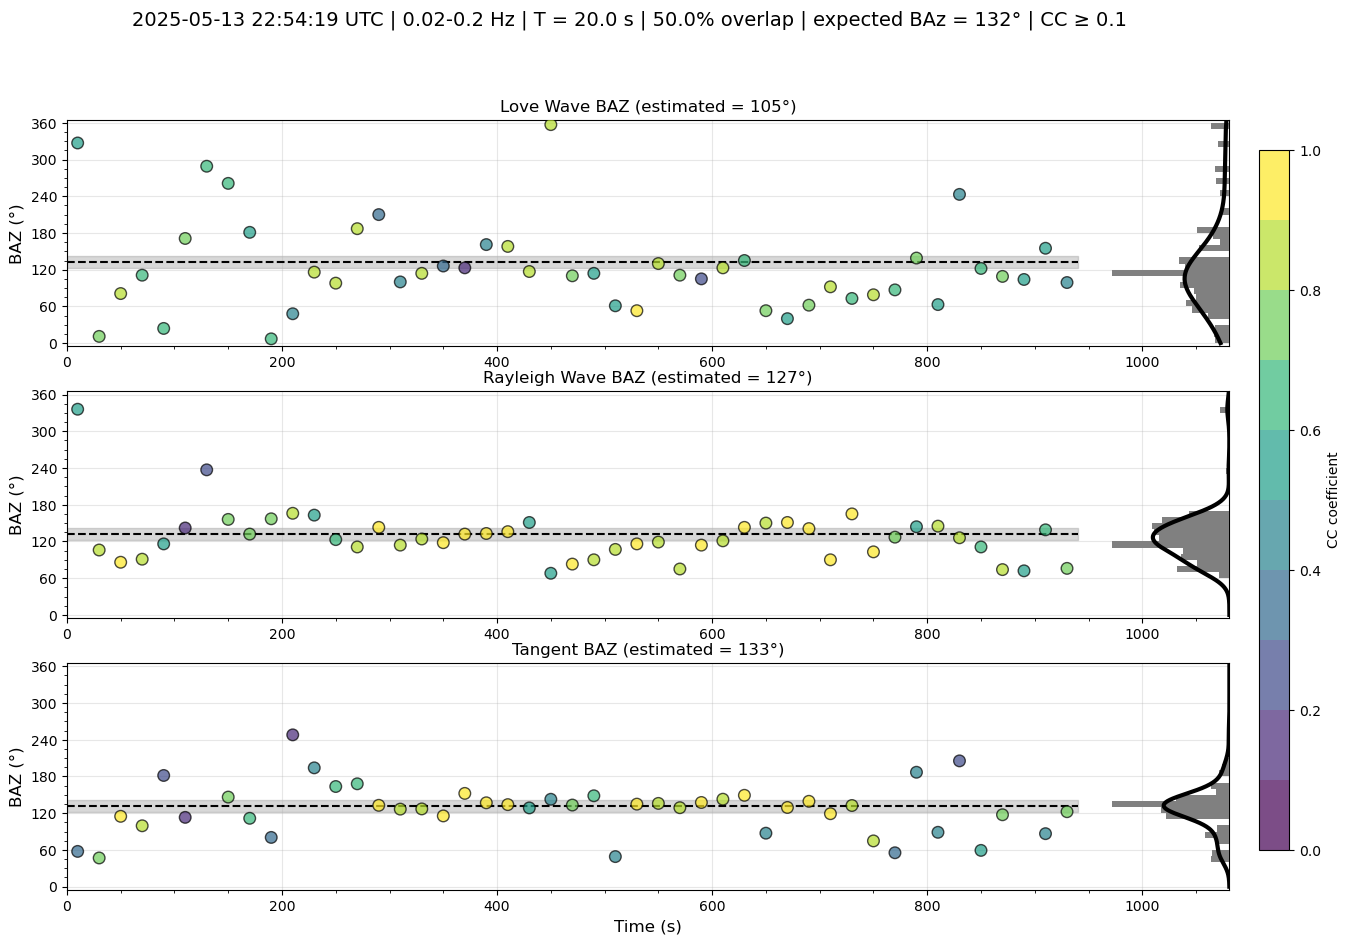

In [40]:
fig, results = sd.compare_backazimuth_methods(
    Twin=20.0,
    Toverlap=0.5,
    invert_rot_z=False,
    invert_acc_z=False,
    cc_threshold=0.1,
    baz_theo=ev['backazimuth'],
    plot=True,
    output=True
)

In [ ]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# import numpy as np

# # Get the data
# fc = results['frequency_bands']['center']  # Shape: (23,)
# baz = results['baz_grid']                  # Shape: (360,)
# kde1 = results['wave_types']['love']['kde_values']  # Shape: (23, 360)
# kde2 = results['wave_types']['rayleigh']['kde_values']  # Shape: (23, 360)

# # Create meshgrid for 3D plotting
# FREQ, BAZ = np.meshgrid(np.log10(fc), np.arange(0,360))  # Both will have shape (360, 23)


# # Create the 3D plots
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12), subplot_kw={'projection': '3d'})

# # Wireframe plot
# ax1.plot_wireframe(BAZ, FREQ, kde1.T, rstride=0, alpha=0.7)
# ax1.set_ylabel('Frequency (Hz)')
# ax1.set_xlabel('Backazimuth (°)')
# ax1.set_zlabel('KDE Value')
# ax1.set_title("3D Wireframe: Love Wave KDE")

# # Wireframe plot
# ax2.plot_wireframe(BAZ, FREQ, kde2.T, rstride=0, alpha=0.7)
# ax2.set_ylabel('Frequency (Hz)')
# ax2.set_xlabel('Backazimuth (°)')
# ax2.set_zlabel('KDE Value')
# ax2.set_title("3D Wireframe: Rayleigh Wave KDE")


# plt.tight_layout()
# plt.show()